# Example of inference a net vis for nectarines
The following document contains a notebook example about how to perform inference with models trained by py-faster-rcnn and how to visualize some parts of the convnet.

In [1]:
%matplotlib inline
from os.path import isfile

import _init_paths
from fast_rcnn.config import cfg, cfg_from_file
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse

/root/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
CLASSES = ('__background__',
           'nectarine')

NETS = {'vgg16': ('VGG16',
                  'VGG16_faster_rcnn_final.caffemodel'),
        'zf': ('ZF',
                  'ZF_faster_rcnn_final.caffemodel')}

In [3]:
def vis_detections(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()

In [12]:
def process_image(net, im_file):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    CONF_THRESH = 0.5
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)

In [13]:
# Paths
rootpath = "/tileo/py-faster-rcnn-fork/"
kitpath = ""
prototxt = rootpath + "models/nectarines/VGG16/faster_rcnn_end2end/test.prototxt"
cfgfile = rootpath + "experiments/cfgs/faster_rcnn_end2end.yml"
#caffemodel = rootpath + "output/faster_rcnn_end2end/nectarine_trainval/vgg16_faster_rcnn_iter_18000.caffemodel"
caffemodel = rootpath + "output/faster_rcnn_end2end/nectarine_trainval/vgg16_faster_rcnn_iter_6000.caffemodel"

In [14]:
# Loading the network
gpu_device = 0
cfg_from_file(cfgfile)
# caffe.set_mode_cpu()
caffe.set_mode_gpu()
caffe.set_device(gpu_device)
cfg.GPU_ID = gpu_device
net = caffe.Net(prototxt, caffemodel, caffe.TEST)
# Warmup on a dummy image
im = 128 * np.ones((300, 500, 3), dtype=np.uint8)
for i in xrange(2):
    _, _= im_detect(net, im)
print '\n\nLoaded network {:s}'.format(caffemodel)



Loaded network /tileo/py-faster-rcnn-fork/output/faster_rcnn_end2end/nectarine_trainval/vgg16_faster_rcnn_iter_6000.caffemodel


Detection took 4.871s for 300 object proposals


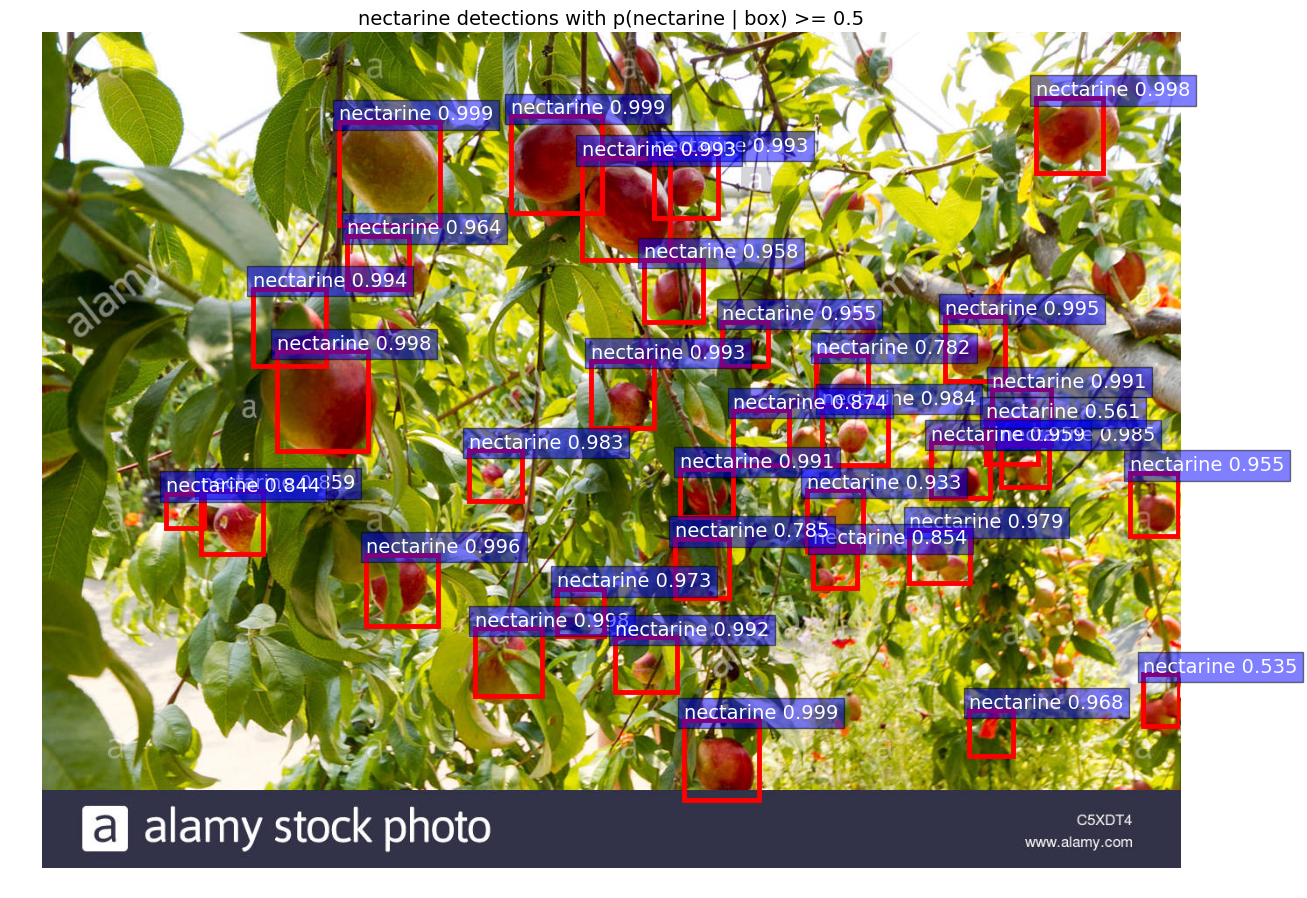

In [15]:
# Inference
imagespath = "/tileo/py-faster-rcnn-fork/data/nectarines/JPEGImages/"
image = imagespath + "080.jpg"
process_image(net, image)

In [9]:
# Based on http://nbviewer.jupyter.org/github/BVLC/caffe/blob/master/examples/00-classification.ipynb
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 600, 816)
im_info	(1, 3)
conv1_1	(1, 64, 600, 816)
conv1_2	(1, 64, 600, 816)
pool1	(1, 64, 300, 408)
conv2_1	(1, 128, 300, 408)
conv2_2	(1, 128, 300, 408)
pool2	(1, 128, 150, 204)
conv3_1	(1, 256, 150, 204)
conv3_2	(1, 256, 150, 204)
conv3_3	(1, 256, 150, 204)
pool3	(1, 256, 75, 102)
conv4_1	(1, 512, 75, 102)
conv4_2	(1, 512, 75, 102)
conv4_3	(1, 512, 75, 102)
pool4	(1, 512, 38, 51)
conv5_1	(1, 512, 38, 51)
conv5_2	(1, 512, 38, 51)
conv5_3	(1, 512, 38, 51)
conv5_3_relu5_3_0_split_0	(1, 512, 38, 51)
conv5_3_relu5_3_0_split_1	(1, 512, 38, 51)
rpn/output	(1, 512, 38, 51)
rpn/output_rpn_relu/3x3_0_split_0	(1, 512, 38, 51)
rpn/output_rpn_relu/3x3_0_split_1	(1, 512, 38, 51)
rpn_cls_score	(1, 18, 38, 51)
rpn_bbox_pred	(1, 36, 38, 51)
rpn_cls_score_reshape	(1, 2, 342, 51)
rpn_cls_prob	(1, 2, 342, 51)
rpn_cls_prob_reshape	(1, 18, 38, 51)
rois	(300, 5)
pool5	(300, 512, 7, 7)
fc6	(300, 4096)
fc7	(300, 4096)
fc7_drop7_0_split_0	(300, 4096)
fc7_drop7_0_split_1	(300, 4096)
cls_score	(300

In [10]:
# Net parameters
# The parameters are exposed as another OrderedDict, net.params. 
# We need to index the resulting values with either [0] for weights or [1] for biases.

# The param shapes typically have the form (output_channels, input_channels, filter_height, filter_width) 
# (for the weights) and the 1-dimensional shape (output_channels,) (for the biases).

for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1_1	(64, 3, 3, 3) (64,)
conv1_2	(64, 64, 3, 3) (64,)
conv2_1	(128, 64, 3, 3) (128,)
conv2_2	(128, 128, 3, 3) (128,)
conv3_1	(256, 128, 3, 3) (256,)
conv3_2	(256, 256, 3, 3) (256,)
conv3_3	(256, 256, 3, 3) (256,)
conv4_1	(512, 256, 3, 3) (512,)
conv4_2	(512, 512, 3, 3) (512,)
conv4_3	(512, 512, 3, 3) (512,)
conv5_1	(512, 512, 3, 3) (512,)
conv5_2	(512, 512, 3, 3) (512,)
conv5_3	(512, 512, 3, 3) (512,)
rpn_conv/3x3	(512, 512, 3, 3) (512,)
rpn_cls_score	(18, 512, 1, 1) (18,)
rpn_bbox_pred	(36, 512, 1, 1) (36,)
fc6	(4096, 25088) (4096,)
fc7	(4096, 4096) (4096,)
cls_score	(2, 4096) (2,)
bbox_pred	(8, 4096) (8,)


In [11]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data,interpolation='nearest'); plt.axis('off')

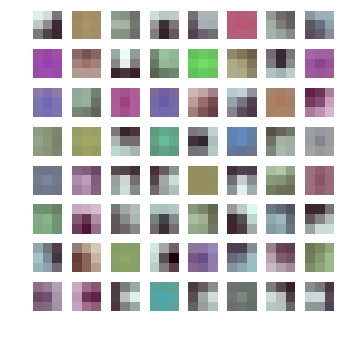

In [12]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1_1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

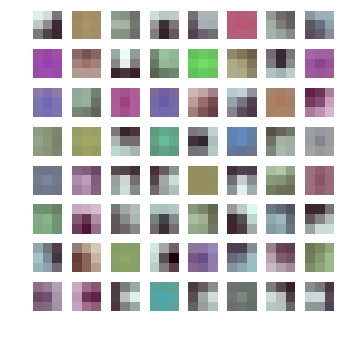

In [13]:
# Comparing with original imagenet model. As can be seen, almost no sensible changes has been
# produced in first conv layer. It have sense.
imagenetcaffemodel = rootpath + "data/imagenet_models/VGG16.v2.caffemodel"
net2 = caffe.Net(prototxt, imagenetcaffemodel, caffe.TEST)
filters = net2.params['conv1_1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

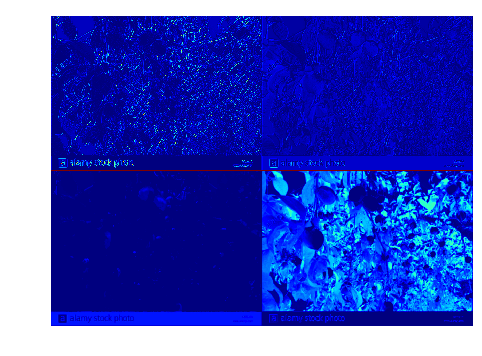

In [14]:
# The first layer output, conv1_2 (rectified responses of the filters above, first 4 only)
feat = net.blobs['conv1_2'].data[0, :4]
vis_square(feat)

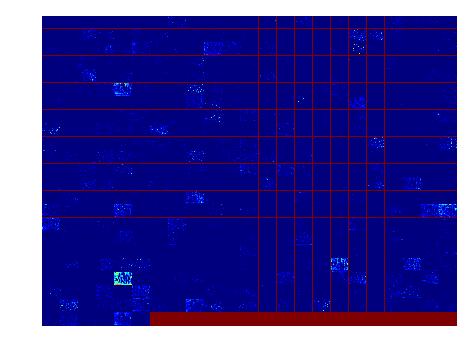

In [15]:
feat = net.blobs['conv5_3_relu5_3_0_split_0'].data[0]
vis_square(feat)

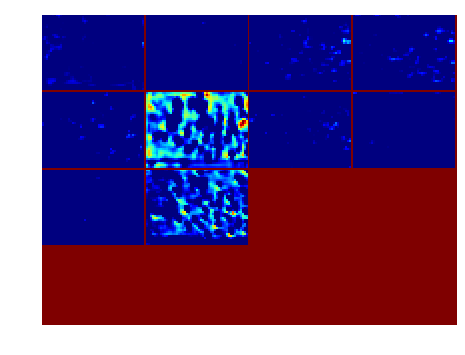

In [16]:
feat = net.blobs['conv5_3_relu5_3_0_split_0'].data[0, 425:435]
vis_square(feat)

(-0.5, 1299.5, 955.5, -0.5)

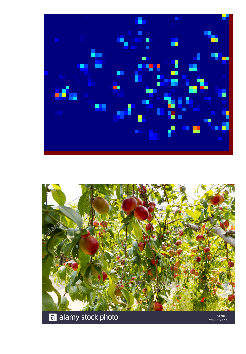

In [17]:
# An example of pool4 activations for one feature (508) compared with the original image
feat = net.blobs['pool4'].data[0, 508:509]
plt.subplot(2, 1, 1)
vis_square(feat)
plt.subplot(2, 1, 2)
plt.imshow(cv2.imread(image)[:, :, (2, 1, 0)], aspect='equal')
plt.axis('off')

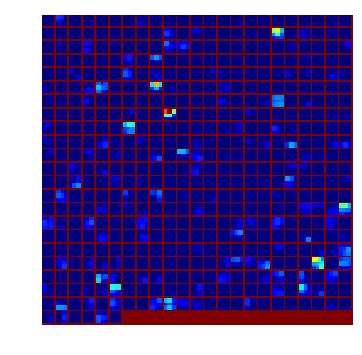

In [18]:
# Pool5 activations for bounding box number 1 (there are 300 bounding boxes)
feat = net.blobs['pool5'].data[1]
vis_square(feat)